In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [81]:
import sys
import os

# Add the path to your sedproxy directory
sys.path.insert(0, '/Users/tanaya/USC/sedproxy')

# Import directly
from clim_to_proxy_clim import clim_to_proxy_clim

from plot_pfms import plot_pfms
from bioturbation_weights import bioturbation_weights
from proxy_conversion import proxy_conversion

In [82]:
def create_ts_matrix(data, start_time=None):
    """
    Python equivalent of R's ts() function for creating time series matrix
    """
    return {
        'data': np.array(data),
        'start': start_time if start_time is not None else 0
    }

def crossing(**kwargs):
    """
    Python equivalent of R's crossing() function from tidyr
    Creates all combinations of input variables
    """
    keys = list(kwargs.keys())
    values = list(kwargs.values())
    combinations = list(product(*values))
    df = pd.DataFrame(combinations, columns=keys)
    return df

In [83]:
clim_data = np.repeat([1, 2], 50000)
clim_in = clim_data.reshape(-1, 1)  # Direct numpy array, not dictionary

print(f"Climate data shape: {clim_in.shape}")
print(f"First 10 values: {clim_in[:10].flatten()}")
print(f"Last 10 values: {clim_in[-10:].flatten()}")

Climate data shape: (100000, 1)
First 10 values: [1 1 1 1 1 1 1 1 1 1]
Last 10 values: [2 2 2 2 2 2 2 2 2 2]


In [84]:
timepoints = np.arange(45000, 55001, 100)  # This should be within 0-99999 range

# But let's make sure they're valid
max_valid_timepoint = len(clim_in) - 1
timepoints = timepoints[timepoints <= max_valid_timepoint]

print(f"Number of timepoints: {len(timepoints)}")
print(f"Timepoint range: {timepoints.min()} to {timepoints.max()}")
print(f"Climate signal length: {len(clim_in)}")
print(f"All timepoints valid? {timepoints.max() < len(clim_in)}")


Number of timepoints: 101
Timepoint range: 45000 to 55000
Climate signal length: 100000
All timepoints valid? True


In [85]:
expts_fig1 = crossing(
    SAR=[6.66, 10, 20, 50],
    taxon=['warm_opt', 'constant', 'cold_opt']
)

print("Experiments DataFrame:")
print(expts_fig1)


Experiments DataFrame:
      SAR     taxon
0    6.66  warm_opt
1    6.66  constant
2    6.66  cold_opt
3   10.00  warm_opt
4   10.00  constant
5   10.00  cold_opt
6   20.00  warm_opt
7   20.00  constant
8   20.00  cold_opt
9   50.00  warm_opt
10  50.00  constant
11  50.00  cold_opt


In [86]:
n_seasons = clim_in.shape[1]  # Should be 1 for your current setup
print(f"Climate signal has {n_seasons} columns (seasons/months)")

# Create seasonal/monthly weights instead of per-timestep weights
if n_seasons == 1:
    # If only 1 column, just use equal weights
    warm_opt_wts = np.array([1.0])
    cold_opt_wts = np.array([1.0])  
    no_wts = np.array([1.0])
else:
    # If multiple columns, create seasonal bias
    # This would be used if you had monthly data
    warm_opt_wts = np.ones(n_seasons)
    cold_opt_wts = np.ones(n_seasons)
    no_wts = np.ones(n_seasons)

print(f"Habitat weights shape: {warm_opt_wts.shape}")
print(f"warm_opt weights: {warm_opt_wts}")
print(f"cold_opt weights: {cold_opt_wts}")
print(f"constant weights: {no_wts}")

# Alternative: Create weights based on climate values at each timepoint
def create_dynamic_weights(clim_signal, timepoints, weight_type):
    """Create habitat weights based on climate values at specific timepoints"""
    weights = []
    for tp in timepoints:
        if tp < len(clim_signal):
            clim_val = clim_signal[tp, 0]  # Get climate value at this timepoint
            if weight_type == 'warm_opt':
                # High weight when warm (clim_val = 1), low when cold (clim_val = 2)
                weight = 100 if clim_val == 1 else 10
            elif weight_type == 'cold_opt':
                # High weight when cold (clim_val = 2), low when warm (clim_val = 1)  
                weight = 100 if clim_val == 2 else 10
            else:  # constant
                weight = 1
            weights.append(weight)
        else:
            weights.append(1)  # Default weight
    return np.array(weights)

print("\n=== Creating dynamic weights per timepoint ===")
warm_opt_wts_dynamic = create_dynamic_weights(clim_in, timepoints, 'warm_opt')
cold_opt_wts_dynamic = create_dynamic_weights(clim_in, timepoints, 'cold_opt')
no_wts_dynamic = create_dynamic_weights(clim_in, timepoints, 'constant')

print(f"Dynamic weights shape: {warm_opt_wts_dynamic.shape}")
print(f"warm_opt dynamic unique values: {np.unique(warm_opt_wts_dynamic)}")
print(f"cold_opt dynamic unique values: {np.unique(cold_opt_wts_dynamic)}")
print(f"constant dynamic unique values: {np.unique(no_wts_dynamic)}")

print("\n=== Variables created ===")
print("Static weights:", ['warm_opt_wts', 'cold_opt_wts', 'no_wts'])
print("Dynamic weights:", ['warm_opt_wts_dynamic', 'cold_opt_wts_dynamic', 'no_wts_dynamic'])

Climate signal has 1 columns (seasons/months)
Habitat weights shape: (1,)
warm_opt weights: [1.]
cold_opt weights: [1.]
constant weights: [1.]

=== Creating dynamic weights per timepoint ===
Dynamic weights shape: (101,)
warm_opt dynamic unique values: [ 10 100]
cold_opt dynamic unique values: [ 10 100]
constant dynamic unique values: [1]

=== Variables created ===
Static weights: ['warm_opt_wts', 'cold_opt_wts', 'no_wts']
Dynamic weights: ['warm_opt_wts_dynamic', 'cold_opt_wts_dynamic', 'no_wts_dynamic']


In [87]:
def process_experiment_group(row, clim_signal, timepoints, weight_dict):
    """
    Process a single experiment group (equivalent to the do() operation in R)
    """
    SAR = row['SAR']
    taxon = row['taxon']
    
    # Select habitat weights based on taxon
    habitat_weights = weight_dict[taxon]
    
    # Call your clim_to_proxy_clim function
    PFM = clim_to_proxy_clim(
        clim_signal=clim_signal,
        timepoints=timepoints,
        habitat_weights=habitat_weights,
        sed_acc_rate=SAR
    )
    
    # Debug: Check what we got back
    print(f"  PFM keys: {list(PFM.keys())}")
    simulated_proxy = PFM['simulated_proxy']
    print(f"  simulated_proxy type: {type(simulated_proxy)}")
    
    # Convert to numpy array if it's a pandas object
    if isinstance(simulated_proxy, (pd.DataFrame, pd.Series)):
        print("  Converting pandas object to numpy array")
        if isinstance(simulated_proxy, pd.DataFrame):
            # If DataFrame, take first column
            simulated_proxy_array = simulated_proxy.iloc[:, 0].values
        else:
            # If Series, get values
            simulated_proxy_array = simulated_proxy.values
    else:
        # Convert to numpy array
        simulated_proxy_array = np.asarray(simulated_proxy)
    
    print(f"  simulated_proxy_array shape: {simulated_proxy_array.shape}")
    
    # Handle multi-dimensional arrays
    if len(simulated_proxy_array.shape) > 1:
        # If it's 2D, take the first column/replicate
        if len(simulated_proxy_array.shape) == 2:
            simulated_proxy_1d = simulated_proxy_array[:, 0]  # Take first replicate
        else:
            simulated_proxy_1d = simulated_proxy_array.flatten()  # Flatten if higher dimensions
    else:
        simulated_proxy_1d = simulated_proxy_array
    
    print(f"  Final 1D array shape: {simulated_proxy_1d.shape}")
    
    # Ensure we have the right length
    if len(simulated_proxy_1d) != len(timepoints):
        print(f"  Warning: simulated_proxy length ({len(simulated_proxy_1d)}) != timepoints length ({len(timepoints)})")
        # Take first n values if longer, pad with NaN if shorter
        if len(simulated_proxy_1d) > len(timepoints):
            simulated_proxy_1d = simulated_proxy_1d[:len(timepoints)]
        else:
            # Pad with NaN if needed
            padded = np.full(len(timepoints), np.nan)
            padded[:len(simulated_proxy_1d)] = simulated_proxy_1d
            simulated_proxy_1d = padded
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'timepoints': timepoints,
        'simulated_proxy': simulated_proxy_1d,
        'SAR': SAR,
        'taxon': taxon
    })
    
    print(f"  Result DataFrame shape: {result_df.shape}")
    return result_df

In [88]:
weight_dict = {
    'warm_opt': warm_opt_wts,
    'cold_opt': cold_opt_wts,
    'constant': no_wts
}

# Also create dynamic weight dictionary as backup
weight_dict_dynamic = {
    'warm_opt': warm_opt_wts_dynamic,
    'cold_opt': cold_opt_wts_dynamic,
    'constant': no_wts_dynamic
}

print("Static weight dictionary created with keys:", list(weight_dict.keys()))
print("Dynamic weight dictionary created with keys:", list(weight_dict_dynamic.keys()))
print(f"Static weights shape: {weight_dict['constant'].shape}")
print(f"Dynamic weights shape: {weight_dict_dynamic['constant'].shape}")

Static weight dictionary created with keys: ['warm_opt', 'cold_opt', 'constant']
Dynamic weight dictionary created with keys: ['warm_opt', 'cold_opt', 'constant']
Static weights shape: (1,)
Dynamic weights shape: (101,)


In [89]:
results_list = []

for idx, row in expts_fig1.iterrows():
    print(f"Processing: SAR={row['SAR']}, taxon={row['taxon']}")
    result = process_experiment_group(row, clim_in, timepoints, weight_dict)
    results_list.append(result)

# Combine all results
results_fig1 = pd.concat(results_list, ignore_index=True)

print(f"\nResults shape: {results_fig1.shape}")
print("\nFirst few rows:")
print(results_fig1.head())

Processing: SAR=6.66, taxon=warm_opt
  PFM keys: ['everything', 'simulated_proxy', 'smoothed_signal', 'calibration_pars']
  simulated_proxy type: <class 'pandas.core.frame.DataFrame'>
  Converting pandas object to numpy array
  simulated_proxy_array shape: (101,)
  Final 1D array shape: (101,)
  Result DataFrame shape: (101, 4)
Processing: SAR=6.66, taxon=constant
  PFM keys: ['everything', 'simulated_proxy', 'smoothed_signal', 'calibration_pars']
  simulated_proxy type: <class 'pandas.core.frame.DataFrame'>
  Converting pandas object to numpy array
  simulated_proxy_array shape: (101,)
  Final 1D array shape: (101,)
  Result DataFrame shape: (101, 4)
Processing: SAR=6.66, taxon=cold_opt
  PFM keys: ['everything', 'simulated_proxy', 'smoothed_signal', 'calibration_pars']
  simulated_proxy type: <class 'pandas.core.frame.DataFrame'>
  Converting pandas object to numpy array
  simulated_proxy_array shape: (101,)
  Final 1D array shape: (101,)
  Result DataFrame shape: (101, 4)
Processing

In [90]:
results_fig1['SAR'] = pd.Categorical(results_fig1['SAR'])
results_fig1['taxon'] = pd.Categorical(
    results_fig1['taxon'], 
    categories=['constant', 'cold_opt', 'warm_opt'], 
    ordered=True
)

print("Data types after conversion:")
print(results_fig1.dtypes)
print(f"\nSAR categories: {results_fig1['SAR'].cat.categories}")
print(f"Taxon categories: {results_fig1['taxon'].cat.categories}")

Data types after conversion:
timepoints            int64
simulated_proxy       int64
SAR                category
taxon              category
dtype: object

SAR categories: Index([6.66, 10.0, 20.0, 50.0], dtype='float64')
Taxon categories: Index(['constant', 'cold_opt', 'warm_opt'], dtype='object')


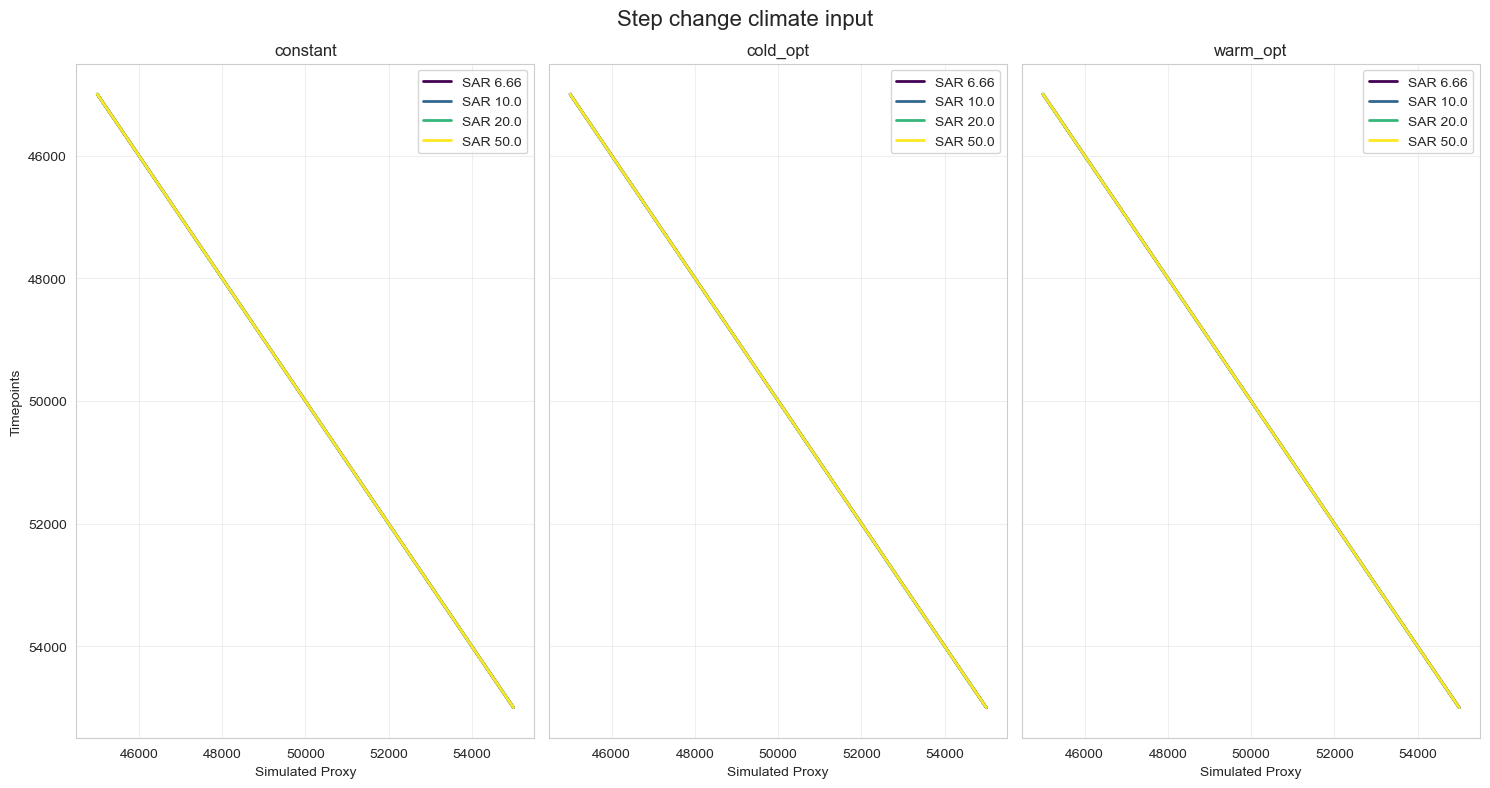

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

taxa = ['constant', 'cold_opt', 'warm_opt']
colors = plt.cm.viridis(np.linspace(0, 1, len(results_fig1['SAR'].unique())))

for i, taxon in enumerate(taxa):
    ax = axes[i]
    
    # Filter data for this taxon
    taxon_data = results_fig1[results_fig1['taxon'] == taxon]
    
    # Plot lines for each SAR value
    for j, sar in enumerate(sorted(taxon_data['SAR'].unique())):
        sar_data = taxon_data[taxon_data['SAR'] == sar]
        ax.plot(sar_data['simulated_proxy'], sar_data['timepoints'], 
               label=f'SAR {sar}', linewidth=2, color=colors[j])
    
    # Customize subplot
    ax.set_title(f'{taxon}')
    ax.set_ylabel('Timepoints' if i == 0 else '')
    ax.set_xlabel('Simulated Proxy')
    ax.invert_yaxis()  # Equivalent to coord_flip() + scale_x_reverse()
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Step change climate input', fontsize=16)
plt.tight_layout()
plt.show()

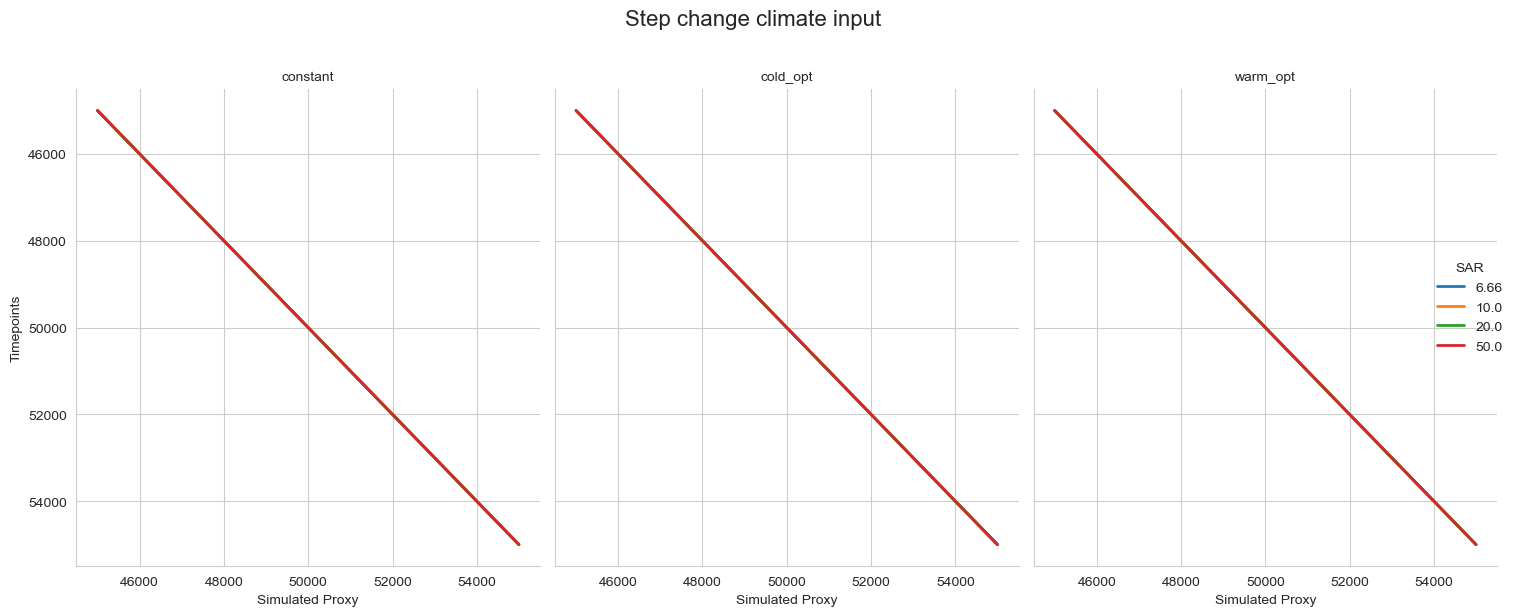

In [92]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(results_fig1, col='taxon', col_order=['constant', 'cold_opt', 'warm_opt'],
                  height=6, aspect=0.8)

# Map the line plot
g.map_dataframe(sns.lineplot, x='simulated_proxy', y='timepoints', 
                hue='SAR', linewidth=2)

# Customize
g.set_axis_labels('Simulated Proxy', 'Timepoints')
g.set_titles('{col_name}')
g.fig.suptitle('Step change climate input', y=1.02, fontsize=16)

# Invert y-axis for all subplots (equivalent to coord_flip() + scale_x_reverse())
for ax in g.axes.flat:
    ax.invert_yaxis()

# Add legend
g.add_legend(title='SAR')

plt.tight_layout()
plt.show()

In [93]:
print("=== DEBUGGING INPUTS ===")
print(f"Climate signal shape: {clim_in.shape}")
print(f"Climate signal unique values: {np.unique(clim_in)}")
print(f"Timepoints range: {timepoints.min()} to {timepoints.max()}")
print(f"Number of timepoints: {len(timepoints)}")

print("\n=== HABITAT WEIGHTS ===")
for taxon, weights in weight_dict.items():
    print(f"{taxon}:")
    print(f"  Shape: {weights.shape}")
    print(f"  Unique values: {np.unique(weights)}")
    print(f"  First 10 values: {weights[:10]}")
    print(f"  Mean: {np.mean(weights):.3f}")
    print()

print("=== CHECKING RELATIONSHIP ===")
print(f"Climate data length: {len(clim_in)}")
print(f"Habitat weights length: {len(weight_dict['constant'])}")
print(f"Are they the same length? {len(clim_in) == len(weight_dict['constant'])}")

# Check if timepoints are valid indices into climate signal
print(f"\nTimepoints vs climate signal:")
print(f"Max timepoint: {timepoints.max()}")
print(f"Climate signal length: {len(clim_in)}")
print(f"Are timepoints valid indices? {timepoints.max() < len(clim_in)}")

# Let's also check what a sample function call returns
print("\n=== SAMPLE FUNCTION CALL ===")
sample_result = clim_to_proxy_clim(
    clim_signal=clim_in,
    timepoints=timepoints[:5],  # Just first 5 timepoints
    habitat_weights=weight_dict['constant'][:len(clim_in)],  # Make sure it matches
    sed_acc_rate=50
)
print(f"Sample result keys: {list(sample_result.keys())}")
print(f"Sample simulated_proxy shape: {sample_result['simulated_proxy'].shape}")
print(f"Sample simulated_proxy values: {sample_result['simulated_proxy'][:5] if hasattr(sample_result['simulated_proxy'], '__len__') else sample_result['simulated_proxy']}")

=== DEBUGGING INPUTS ===
Climate signal shape: (100000, 1)
Climate signal unique values: [1 2]
Timepoints range: 45000 to 55000
Number of timepoints: 101

=== HABITAT WEIGHTS ===
warm_opt:
  Shape: (1,)
  Unique values: [1.]
  First 10 values: [1.]
  Mean: 1.000

cold_opt:
  Shape: (1,)
  Unique values: [1.]
  First 10 values: [1.]
  Mean: 1.000

constant:
  Shape: (1,)
  Unique values: [1.]
  First 10 values: [1.]
  Mean: 1.000

=== CHECKING RELATIONSHIP ===
Climate data length: 100000
Habitat weights length: 1
Are they the same length? False

Timepoints vs climate signal:
Max timepoint: 55000
Climate signal length: 100000
Are timepoints valid indices? True

=== SAMPLE FUNCTION CALL ===
Sample result keys: ['everything', 'simulated_proxy', 'smoothed_signal', 'calibration_pars']
Sample simulated_proxy shape: (5, 3)
Sample simulated_proxy values:    timepoints  simulated_proxy  reconstructed_climate
0       45000              1.0                    1.0
1       45100              1.0    